<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/malaria_botella_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTE MODELO TIENE TRES PROBLEMAS: INFIERE AL 100X100 DE PRECISION.
NO SE SABE DE DONDE TOMA LOS PESOS NI EN Q PARTE LOS INJECTA.
AL FINAL MUESTRA POCAS FOTOS DESPUES DE INFERIR LA CARPETA DE VALIDACION.
POR LAS DUDAS, ASEGURARSE QUE EL LOS TRES DATASETS, CONTENGAN FOTOS TOTALMENTE DIFERENTES.

In [22]:
from google.colab import drive

In [23]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import cv2

img = cv2.imread("/content/drive/MyDrive/malaria_botellas/Parasitized/anomalo1.jpg")
img.shape

(480, 640, 3)

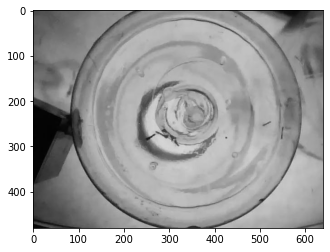

In [25]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [72]:
img_dir = "/content/drive/MyDrive/malaria_botellas"



In [73]:
import tensorflow as tf

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,                                                                                                                   
                                                           #rotation_range=0.2,  "estos 4 hacen preprocesado"
                                                           #width_shift_range=0.2,
                                                           #height_shift_range=0.2,
                                                           #zoom_range = 0.2, 
                                                           horizontal_flip=True,
                                                           validation_split = 0.25
                                                            )
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.25
                                                          )





In [74]:
train_data = train_gen.flow_from_directory(img_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 32,
                                           classes = ["Parasitized","Uninfected"],
                                           seed = 42,
                                           subset = "training"                                           
                                           )

test_data = test_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Parasitized","Uninfected"],
                                         batch_size = 32,
                                         seed = 42,
                                         subset = "validation"
                                         )



Found 688 images belonging to 2 classes.
Found 228 images belonging to 2 classes.


In [75]:
class_labels = list(train_data.class_indices.keys())

class_labels

['Parasitized', 'Uninfected']

In [76]:
class_labels = list(test_data.class_indices.keys())

class_labels

['Parasitized', 'Uninfected']

In [77]:
image,label = train_data.next()
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 2)


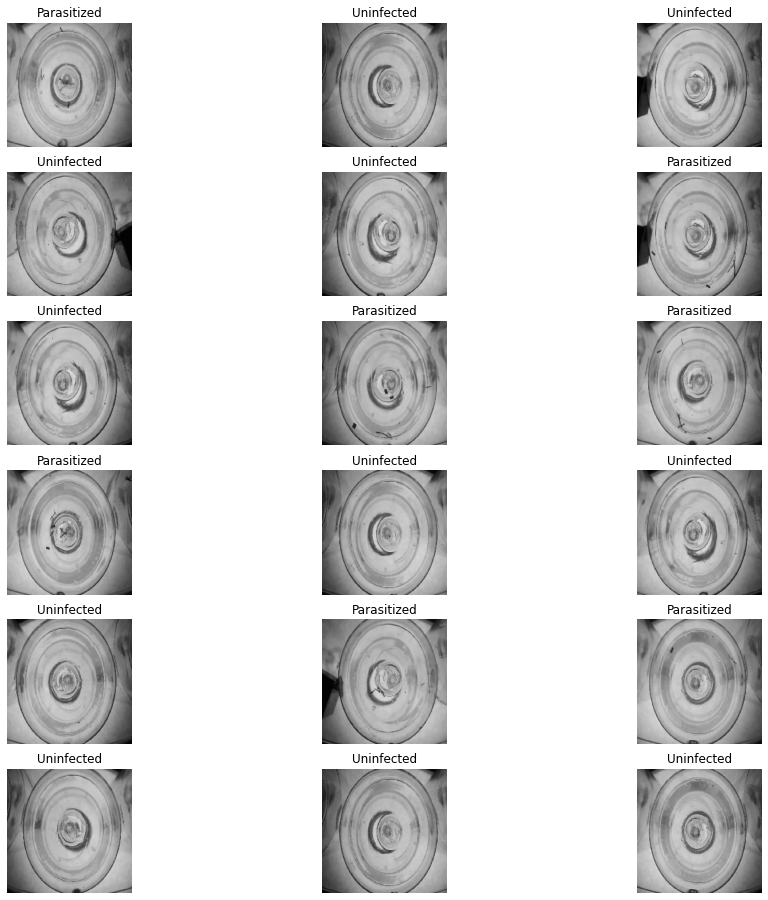

In [78]:
# visualizing the train,  or val ,para q muestre train o test dataset, despues de llegar al final de la notebook, hay que re ejecutar
# todo desde 
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = train_data.next()## visualizar x data

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(class_labels[tf.argmax(label[i])])
  plt.axis("off")


In [79]:
#building a CNN model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             layers.Conv2D(filters=64, kernel_size= 2, activation="relu", input_shape=(224,224,3)),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation="relu"),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 64, kernel_size= 2, activation= "relu"),
                             layers.MaxPooling2D(pool_size = 2),


                             layers.Flatten(),

                             layers.Dense(128, activation= "relu"),
                             layers.Dropout(0.5),
                             layers.Dense(2, activation="softmax"),
])


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [80]:
# compiling the model

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [98]:
# fitting data to the model
model.fit(train_data,
          epochs = 1,
          steps_per_epoch = len(train_data),
          validation_data = test_data,  # test data o val data, para elegir contra que muestras convalidar la precision del modelo al entrenar
          validation_steps = len(test_data)
          )

22/22 [==============================] - 8s 345ms/step - loss: 0.0185 - accuracy: 0.9927 - val_loss: 5.8122e-04 - val_accuracy: 1.0000


In [99]:
model_evaluation = model.evaluate(train_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

22/22 [==============================] - 5s 233ms/step - loss: 0.0023 - accuracy: 1.0000


In [100]:
model_evaluation = model.evaluate(test_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

8/8 [==============================] - 2s 204ms/step - loss: 5.8122e-04 - accuracy: 1.0000


IndexError: ignored

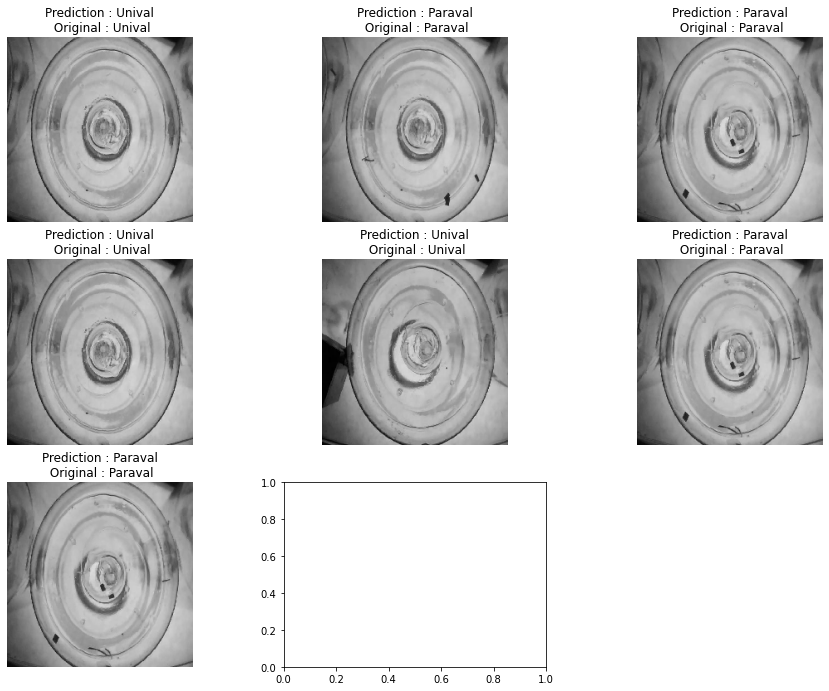

In [101]:
# visualizing the train data, aca tiene q mostrar paratiziced y uninfectd, no unival y paraval.

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = test_data.next()

  model_pred = model.predict(image)

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(f"Prediction : {class_labels[tf.argmax(model_pred[i])]}\n Original : {class_labels[tf.argmax(label[i])]}")
  plt.subplots_adjust(top = 1.25)
  plt.axis("off")

In [112]:
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.,
                                                          validation_split = 0.99
                                                          )

val_data = val_gen.flow_from_directory(img_dir,
                                         target_size = (224,224),
                                         class_mode = "categorical",
                                         classes = ["Paraval","Unival"],
                                         batch_size = 32,
                                         seed = 42,
                                         subset = "validation"
                                         )

Found 139 images belonging to 2 classes.


In [113]:
image,label = val_data.next()
print(image.shape)
print(label.shape)  # el 1er numero el el batch siza elegido x mi arriba

(32, 224, 224, 3)
(32, 2)


In [114]:
class_labels = list(val_data.class_indices.keys())

class_labels

['Paraval', 'Unival']

In [110]:
model_evaluation = model.evaluate(val_data) # poner aca train_data, test_data, o val_data para evaluar inferencia con data de train, test o validacion.

2/2 [==============================] - 0s 16ms/step - loss: 9.8479e-04 - accuracy: 1.0000


IndexError: ignored

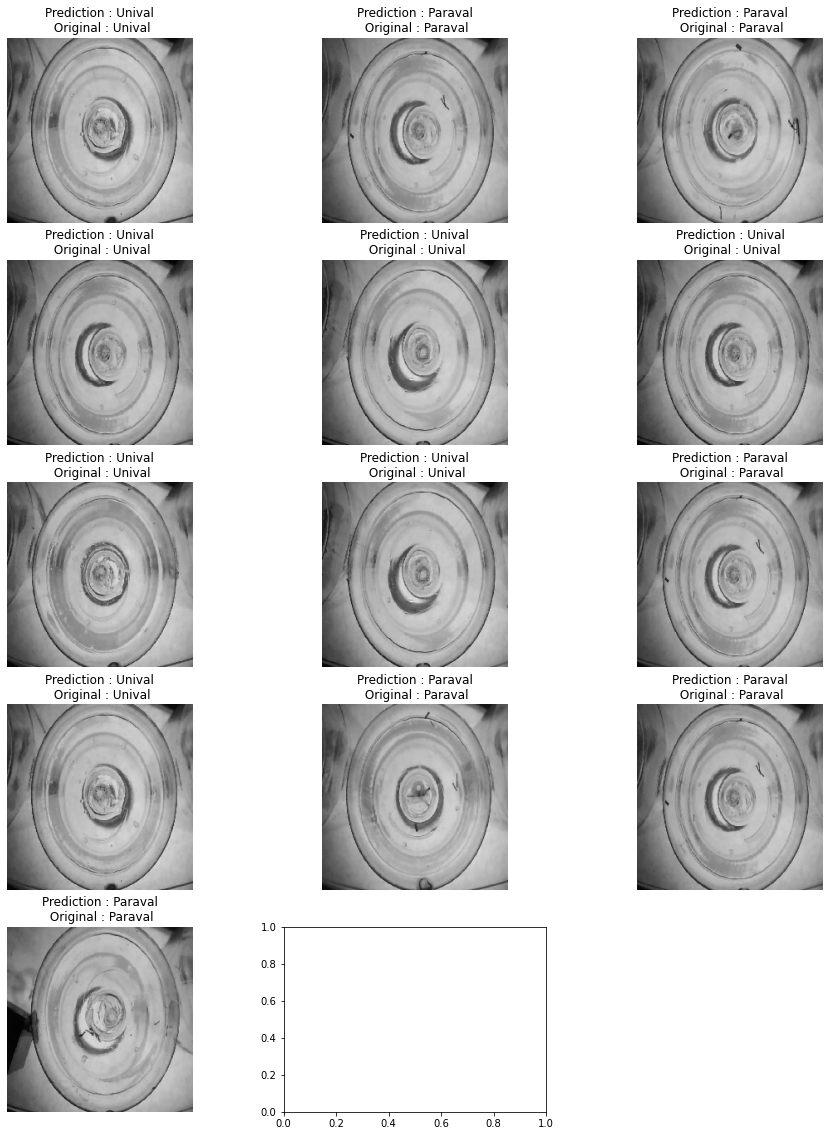

In [115]:
# visualizing the train data

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,16))

for i in range(18):

  image,label = val_data.next()

  model_pred = model.predict(image)

  plt.subplot(6,3,i+1)
  plt.imshow(image[i])
  plt.title(f"Prediction : {class_labels[tf.argmax(model_pred[i])]}\n Original : {class_labels[tf.argmax(label[i])]}")
  plt.subplots_adjust(top = 1.25)
  plt.axis("off")